### Import libraries

In [573]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression,Lasso,Ridge,SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error
import pickle

### Define useful functions

In [1343]:
def extract_zip_code(hotel_address):
    address_tmp = hotel_address.split(',')[-2].strip(' ').split(' ')[-1][:3]
    if address_tmp == 'NY1':
        return hotel_address.split(',')[-2].strip(' ').split(' ')[-1][2:5]
    else:
        return address_tmp

def extract_zip_code_5dig(hotel_address):
    address_tmp = hotel_address.split(',')[-2].strip(' ').split(' ')[-1][:5]
    if address_tmp == 'NY1':
        return hotel_address.split(',')[-2].strip(' ').split(' ')[-1][2:7]
    else:
        return address_tmp
    
def extract_price(hotel_room_price):
    room_price_tmp = hotel_room_price.strip('\r').strip('US$')
    if room_price_tmp == '':
        return None
    else:
        room_price_tmp = room_price_tmp.replace(',' , '')
        return float(room_price_tmp)
    
def extract_capacity(hotel_room_capacity):
    if pd.isnull(hotel_room_capacity):
        return None
    else:
        return int(hotel_room_capacity[-1])
       
def extract_hotel_stars(hotel_stars):
    if hotel_stars in ['1 stars', '1-star hotel']:
        return 1.0
    elif hotel_stars in ['1.5 stars', '1.5 star hotel']:
        return 1.5
    elif hotel_stars in ['2 stars', '2-star hotel']:
        return 2.0
    elif hotel_stars in ['2.5 stars', '2.5 star hotel']:
        return 2.5
    elif hotel_stars in ['3 stars', '3-star hotel']:
        return 3.0
    elif hotel_stars in ['3.5 stars', '3.5 star hotel']:
        return 3.5
    elif hotel_stars in ['4 stars', '4-star hotel']:
        return 4.0
    elif hotel_stars in ['4.5 stars', '4.5 star hotel']:
        return 4.5
    elif hotel_stars in ['5 stars', '5-star hotel']:
        return 5.0
    else:
        return None
    
def extract_cleanliness_rating(hotel_rating_breakdown):
    item_tmp = hotel_rating_breakdown.strip('[]').split('], [')[0]
    if item_tmp.split(',')[0]=="'Cleanliness'":
        return float(item_tmp.split(',')[1].strip(' ').strip("''"))
    else:
        return None
    
def extract_comfort_rating(hotel_rating_breakdown):
    item_tmp = hotel_rating_breakdown.strip('[]').split('], [')[1]
    if item_tmp.split(',')[0]=="'Comfort'":
        return float(item_tmp.split(',')[1].strip(' ').strip("''"))
    else:
        return None
    
def extract_location_rating(hotel_rating_breakdown):
    item_tmp = hotel_rating_breakdown.strip('[]').split('], [')[2]
    if item_tmp.split(',')[0]=="'Location'":
        return float(item_tmp.split(',')[1].strip(' ').strip("''"))
    else:
        return None
    
def extract_facilities_rating(hotel_rating_breakdown):
    item_tmp = hotel_rating_breakdown.strip('[]').split('], [')[3]
    if item_tmp.split(',')[0]=="'Facilities'":
        return float(item_tmp.split(',')[1].strip(' ').strip("''"))
    else:
        return None
    
def extract_staff_rating(hotel_rating_breakdown):
    item_tmp = hotel_rating_breakdown.strip('[]').split('], [')[4]
    if item_tmp.split(',')[0]=="'Staff'":
        return float(item_tmp.split(',')[1].strip(' ').strip("''"))
    else:
        return None
    
def extract_value_rating(hotel_rating_breakdown):
    item_tmp = hotel_rating_breakdown.strip('[]').split('], [')[5]
    if item_tmp.split(',')[0]=="'Value for money'":
        return float(item_tmp.split(',')[1].strip(' ').strip("''"))
    else:
        return None
    
def extract_wifi_rating(hotel_rating_breakdown):
    item_tmp = hotel_rating_breakdown.strip('[]').split('], [')
    if len(item_tmp)<7:
        return None
    elif item_tmp[6].split(',')[0]=="'Free WiFi'":
        return float(item_tmp[6].split(',')[1].strip(' ').strip("''"))
    else:
        return None
    
def display_info_hotel(df_hotels_item):
    print('Hotel name: ',df_hotels_item['hotel_name'].values[0])
    print('---------------------')
    print('Negative mentions per topic: ')
    print('(0) Room Comfort: ', str(int(df_hotels_item['0_neg'])))
    print('(1) Staff: ', str(int(df_hotels_item['1_neg'])))
    print('(2) Breakfast: ', str(int(df_hotels_item['2_neg'])))
    print('(3) Facilities: ', str(int(df_hotels_item['3_neg'])))
    print('(4) Location: ', str(int(df_hotels_item['4_neg'])))
    print('(5) Bathroom: ', str(int(df_hotels_item['5_neg'])))
    print('(6) Room Amenities: ', str(int(df_hotels_item['6_neg'])))
    print('(7) Bed Quality: ', str(int(df_hotels_item['7_neg'])))
    #print('Other/no main topic: ', str(int(df_hotels_item['-1_neg'])))
    
def change_topic_counts(df_hotel_item,counts_delta_vec): 
    df_hotel_item_cp = df_hotel_item.copy()
    df_hotel_item_cp.reset_index(drop=True,inplace=True)
    df_hotel_item_cp.at[0,'0_neg'] += counts_delta_vec[0]
    df_hotel_item_cp.at[0,'1_neg'] += counts_delta_vec[1]
    df_hotel_item_cp.at[0,'2_neg'] += counts_delta_vec[2]
    df_hotel_item_cp.at[0,'3_neg'] += counts_delta_vec[3]
    df_hotel_item_cp.at[0,'4_neg'] += counts_delta_vec[4]
    df_hotel_item_cp.at[0,'5_neg'] += counts_delta_vec[5]
    df_hotel_item_cp.at[0,'6_neg'] += counts_delta_vec[6]
    df_hotel_item_cp.at[0,'7_neg'] += counts_delta_vec[7]
    df_hotel_item_cp[[str(n)+'_pc_neg' for n in range(-1,8)]] = 100*df_hotel_item_cp[[str(n)+'_neg' for n in range(-1,8)]].div(df_hotel_item_cp.sentences_count_neg, axis=0)
    return df_hotel_item_cp

def get_price_prediction(model,cat_feat,feat_compl_list,feat_compl_list_dum,df_hotel_item):
    input_features = df_hotel_item[feat_compl_list]
    input_target = df_hotel_item[['hotel_room_price_per_person_avg']]

    scaled_input = input_features.copy()
    scaled_input = scaled_input.reindex(columns = feat_compl_list_dum, fill_value=0)
    for cat in cat_feat:
        dummy_cat = cat+'_'+str(input_features[cat].values[0])
        if dummy_cat in scaled_input.columns:
            scaled_input.iloc[0, scaled_input.columns.get_loc(dummy_cat)] = 1
            
    price_pred = model.predict(scaled_input)[0][0]
    return price_pred

def update_price(model,cat_feat,feat_compl_list,feat_compl_list_dum,df_hotel_item,counts_delta_vec):
    # baseline price from model
    baseline_price = get_price_prediction(model,cat_feat,feat_compl_list,feat_compl_list_dum,df_hotel_item)
    # change negative mentions per topic
    df_hotel_item_changed = change_topic_counts(df_hotel_item,counts_delta_vec)
    # new price from model
    new_price = get_price_prediction(model,cat_feat,feat_compl_list,feat_compl_list_dum,df_hotel_item_changed)
    # per cent change
    per_cent_change = 100*(new_price-baseline_price)/baseline_price
    # return prices
    return [baseline_price,new_price,per_cent_change]

### Import datasets

In [1474]:
# dataset of detailed info (room price, stars, ratings, location) for each hotel
df_hotel_detailed_info_list = pd.read_csv('./datasets/sample0_nys_hotel_detailed_info_list.csv',lineterminator='\n')
df_hotel_detailed_info_list_2 = pd.read_csv('./datasets/sample1_nys_hotel_detailed_info_list.csv',lineterminator='\n')
df_hotel_detailed_info_list_3 = pd.read_csv('./datasets/sample2_nys_hotel_detailed_info_list.csv',lineterminator='\n')

In [1475]:
# dataset of number of negative mentions per topic for each hotel
df_negative_sentences_by_topic_pt = pd.read_csv('./datasets/df_negative_sentences_by_topic_pt_we.csv',lineterminator='\n')

### Cleaning and pre-processing

In [1476]:
# rename room price, room name, and room capacity columns
df_hotel_detailed_info_list.rename(columns={'hotel_room_price\r': 'hotel_room_price'},inplace=True)
df_hotel_detailed_info_list_2.rename(columns={'hotel_room_price\r': 'hotel_room_price_2','hotel_room_name':'hotel_room_name_2','hotel_room_capacity':'hotel_room_capacity_2'},inplace=True)
df_hotel_detailed_info_list_3.rename(columns={'hotel_room_price\r': 'hotel_room_price_3','hotel_room_name':'hotel_room_name_3','hotel_room_capacity':'hotel_room_capacity_3'},inplace=True)

In [1477]:
# extract zip codes in both 3-digit and 5-digit formats
df_hotel_detailed_info_list = df_hotel_detailed_info_list[~pd.isnull(df_hotel_detailed_info_list['hotel_address'])]
df_hotel_detailed_info_list['hotel_address_zip_code'] = df_hotel_detailed_info_list['hotel_address'].apply(extract_zip_code)
df_hotel_detailed_info_list['hotel_address_zip_code_5dig'] = df_hotel_detailed_info_list['hotel_address'].apply(extract_zip_code_5dig)

In [1478]:
# extract room prices
df_hotel_detailed_info_list['hotel_room_price'] = df_hotel_detailed_info_list['hotel_room_price'].apply(extract_price)
df_hotel_detailed_info_list_2['hotel_room_price_2'] = df_hotel_detailed_info_list_2['hotel_room_price_2'].apply(extract_price)
df_hotel_detailed_info_list_3['hotel_room_price_3'] = df_hotel_detailed_info_list_3['hotel_room_price_3'].apply(extract_price)

In [1479]:
# merge dataframes with room prices 2 and 3 onto main dataframe
df_hotel_detailed_info_list = df_hotel_detailed_info_list.merge(df_hotel_detailed_info_list_2[['hotel_url','hotel_room_price_2','hotel_room_name_2','hotel_room_capacity_2']],on='hotel_url')
df_hotel_detailed_info_list = df_hotel_detailed_info_list.merge(df_hotel_detailed_info_list_3[['hotel_url','hotel_room_price_3','hotel_room_name_3','hotel_room_capacity_3']],on='hotel_url')

In [1480]:
# extract room capacities
df_hotel_detailed_info_list['hotel_room_capacity'] = df_hotel_detailed_info_list['hotel_room_capacity'].apply(extract_capacity)
df_hotel_detailed_info_list['hotel_room_capacity_2'] = df_hotel_detailed_info_list['hotel_room_capacity_2'].apply(extract_capacity)
df_hotel_detailed_info_list['hotel_room_capacity_3'] = df_hotel_detailed_info_list['hotel_room_capacity_3'].apply(extract_capacity)

In [1481]:
# determine room prices per person
df_hotel_detailed_info_list['hotel_room_price_per_person'] = df_hotel_detailed_info_list['hotel_room_price']/df_hotel_detailed_info_list['hotel_room_capacity']
df_hotel_detailed_info_list['hotel_room_price_per_person_2'] = df_hotel_detailed_info_list['hotel_room_price_2']/df_hotel_detailed_info_list['hotel_room_capacity_2']
df_hotel_detailed_info_list['hotel_room_price_per_person_3'] = df_hotel_detailed_info_list['hotel_room_price_3']/df_hotel_detailed_info_list['hotel_room_capacity_3']

In [1482]:
# drop hotels without room prices
df_hotel_detailed_info_list = df_hotel_detailed_info_list[~pd.isnull(df_hotel_detailed_info_list[['hotel_room_price_per_person','hotel_room_price_per_person_2','hotel_room_price_per_person_3']]).any(axis=1)]

In [1483]:
# determine average room price per person for each hotel
df_hotel_detailed_info_list['hotel_room_price_per_person_avg'] = df_hotel_detailed_info_list[['hotel_room_price_per_person','hotel_room_price_per_person_2','hotel_room_price_per_person_3']].mean(axis=1)

In [1484]:
# drop hotels without average room price
df_hotel_detailed_info_list = df_hotel_detailed_info_list[~pd.isnull(df_hotel_detailed_info_list['hotel_room_price_per_person_avg'])]

In [1486]:
# extract aspect ratings
df_hotel_detailed_info_list['hotel_cleanliness_rating'] = df_hotel_detailed_info_list['hotel_rating_breakdown'].apply(extract_cleanliness_rating)
df_hotel_detailed_info_list['hotel_comfort_rating'] = df_hotel_detailed_info_list['hotel_rating_breakdown'].apply(extract_comfort_rating)
df_hotel_detailed_info_list['hotel_location_rating'] = df_hotel_detailed_info_list['hotel_rating_breakdown'].apply(extract_location_rating)
df_hotel_detailed_info_list['hotel_facilities_rating'] = df_hotel_detailed_info_list['hotel_rating_breakdown'].apply(extract_facilities_rating)
df_hotel_detailed_info_list['hotel_staff_rating'] = df_hotel_detailed_info_list['hotel_rating_breakdown'].apply(extract_staff_rating)
df_hotel_detailed_info_list['hotel_value_rating'] = df_hotel_detailed_info_list['hotel_rating_breakdown'].apply(extract_value_rating)
df_hotel_detailed_info_list['hotel_wifi_rating'] = df_hotel_detailed_info_list['hotel_rating_breakdown'].apply(extract_wifi_rating)

In [1487]:
# median imputation for wifi rating (only a few missing values)
hotel_wifi_median = df_hotel_detailed_info_list['hotel_wifi_rating'].median()
df_hotel_detailed_info_list['hotel_wifi_rating'].fillna(hotel_wifi_median,inplace=True)

In [1488]:
# extract hotel stars
df_hotel_detailed_info_list['hotel_stars'] = df_hotel_detailed_info_list['hotel_stars'].apply(extract_hotel_stars)

### Create copy of dataframe

In [1489]:
df_hotel_detailed_info_list_filtered = df_hotel_detailed_info_list.copy()

### Remove hotels without stars (if any)

In [1490]:
df_hotel_detailed_info_list_filtered = df_hotel_detailed_info_list_filtered[~pd.isnull(df_hotel_detailed_info_list_filtered['hotel_stars'])]

### Determine avg room price and std by stars and location

In [1491]:
df_hotel_detailed_info_list_filtered['hotel_room_price_per_person_avg_grouped_mean'] = df_hotel_detailed_info_list_filtered.groupby(['hotel_stars','hotel_address_zip_code_5dig']).transform('mean')['hotel_room_price_per_person_avg']
df_hotel_detailed_info_list_filtered['hotel_room_price_per_person_avg_grouped_std'] = df_hotel_detailed_info_list_filtered.groupby(['hotel_stars','hotel_address_zip_code_5dig']).transform('std')['hotel_room_price_per_person_avg']
#df_hotel_detailed_info_list_filtered = df_hotel_detailed_info_list_filtered[~pd.isnull(df_hotel_detailed_info_list_filtered['hotel_room_price_per_person_avg_grouped_std'])]

In [1493]:
df_hotel_detailed_info_list_filtered['hotel_room_price_per_person_norm'] = df_hotel_detailed_info_list_filtered['hotel_room_price_per_person_avg']-df_hotel_detailed_info_list_filtered['hotel_room_price_per_person_avg_grouped_mean']
df_hotel_detailed_info_list_filtered['hotel_room_price_per_person_norm'] = df_hotel_detailed_info_list_filtered['hotel_room_price_per_person_norm'].div(df_hotel_detailed_info_list_filtered['hotel_room_price_per_person_avg_grouped_std'], axis=0)

In [1494]:
df_hotel_detailed_info_list_filtered['hotel_room_price_per_person_pc_change'] = df_hotel_detailed_info_list_filtered['hotel_room_price_per_person_avg']-df_hotel_detailed_info_list_filtered['hotel_room_price_per_person_avg_grouped_mean']
df_hotel_detailed_info_list_filtered['hotel_room_price_per_person_pc_change'] = df_hotel_detailed_info_list_filtered['hotel_room_price_per_person_pc_change'].div(df_hotel_detailed_info_list_filtered['hotel_room_price_per_person_avg'], axis=0)
#df_hotel_detailed_info_list_filtered = df_hotel_detailed_info_list_filtered[abs(df_hotel_detailed_info_list_filtered['hotel_room_price_per_person_pc_change'])<0.30]

### Join with topic count dataframe

In [1496]:
neg_columns_to_rename = {'-1':'-1_neg','0':'0_neg','1':'1_neg','2':'2_neg','3':'3_neg','4':'4_neg','5':'5_neg','6':'6_neg','7':'7_neg',
                         '-1_pc':'-1_pc_neg','0_pc':'0_pc_neg','1_pc':'1_pc_neg','2_pc':'2_pc_neg','3_pc':'3_pc_neg','4_pc':'4_pc_neg','5_pc':'5_pc_neg','6_pc':'6_pc_neg','7_pc':'7_pc_neg',
                         'sentences_count':'sentences_count_neg'}

In [1497]:
df_negative_sentences_by_topic_pt.rename(columns=neg_columns_to_rename,inplace=True)

In [1498]:
df_hotel_detailed_info_list_filtered_merged = df_hotel_detailed_info_list_filtered.merge(df_negative_sentences_by_topic_pt,on='hotel_url')

### Remove hotels with zero topic counts across all topics (if any)

In [1499]:
df_hotel_detailed_info_list_filtered_merged = df_hotel_detailed_info_list_filtered_merged[~(df_hotel_detailed_info_list_filtered_merged[['0_neg','1_neg','2_neg','3_neg','4_neg','5_neg','6_neg','7_neg']]==0.0).all(axis=1)]

### Select topic features to include in feature set
(and make them explicit percentages)

In [1500]:
topic_features_list = ['0_pc_neg','1_pc_neg','2_pc_neg','3_pc_neg','4_pc_neg','5_pc_neg','6_pc_neg','7_pc_neg']
#topic_features_list = ['0_neg','1_neg','2_neg','3_neg','4_neg','5_neg','6_neg','7_neg','sentences_count_neg']

In [1501]:
df_hotel_detailed_info_list_filtered_merged[topic_features_list] = 100*df_hotel_detailed_info_list_filtered_merged[topic_features_list]

### Print out complete dataset with unique names to csv for web app

In [1503]:
df_hotels_unique_names = df_hotel_detailed_info_list_filtered_merged.copy()
df_hotels_unique_names['hotel_unique_name'] = df_hotels_unique_names['hotel_name'] + ' (' + df_hotels_unique_names['hotel_address_zip_code_5dig'] + ')'
df_hotels_unique_names.to_csv('./input_app/df_hotels_unique_names.csv',index=False)

## Modeling

### Create complete feature set and target

In [1553]:
features_list1 = ['hotel_stars','hotel_overall_rating','hotel_address_zip_code_5dig']
features_list2 = ['hotel_cleanliness_rating','hotel_value_rating','hotel_wifi_rating','hotel_comfort_rating','hotel_facilities_rating','hotel_location_rating','hotel_staff_rating']
features_complete_list = features_list1+features_list2+topic_features_list

df_features = df_hotel_detailed_info_list_filtered_merged[features_complete_list]
df_target = df_hotel_detailed_info_list_filtered_merged[['hotel_room_price_per_person_avg']]

In [1554]:
# checking that feature set is correct
df_features.columns

Index(['hotel_stars', 'hotel_overall_rating', 'hotel_address_zip_code_5dig',
       'hotel_cleanliness_rating', 'hotel_value_rating', 'hotel_wifi_rating',
       'hotel_comfort_rating', 'hotel_facilities_rating',
       'hotel_location_rating', 'hotel_staff_rating', '0_pc_neg', '1_pc_neg',
       '2_pc_neg', '3_pc_neg', '4_pc_neg', '5_pc_neg', '6_pc_neg', '7_pc_neg'],
      dtype='object')

### One-hot encoding for categorical features
(and standardization of numerical features if necessary)

In [1583]:
categorical_features = ['hotel_address_zip_code_5dig']

In [1584]:
train_test_scaled_inputs = df_features.copy()

# train_test_num_features = train_test_scaled_inputs.drop(categorical_features,axis=1)
# no_scaling_features = topic_features_list
# train_test_num_scaled_features = train_test_num_features.drop(no_scaling_features,axis=1)
# train_test_num_scaled_features_col = train_test_num_scaled_features.columns.values
# scaler = StandardScaler()
# scaler.fit(train_test_num_scaled_features.values)
# train_test_num_scaled_features = scaler.transform(train_test_num_scaled_features.values)
# train_test_scaled_inputs[train_test_num_scaled_features_col] = train_test_num_scaled_features

In [1585]:
train_test_scaled_inputs = pd.get_dummies(train_test_scaled_inputs,columns=categorical_features,drop_first=True)

### Train-validation split

In [1586]:
# test_size=0.001 minimizes test set when training model for deployment
x_train, x_val, y_train, y_val = train_test_split(train_test_scaled_inputs,df_target, test_size = 0.001, random_state = 42)

### Linear regression

In [1587]:
reg = LinearRegression()
reg.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [1588]:
y_train_reg_pred = reg.predict(x_train)
y_val_reg_pred = reg.predict(x_val)

In [1589]:
R2_train=reg.score(x_train,y_train)
adj_R2_train=1-(1-R2_train)*(x_train.shape[0]-1)/(x_train.shape[0]-x_train.shape[1]-1)

#R2_val=reg.score(x_val,y_val)
#adj_R2_val=1-(1-R2_val)*(x_val.shape[0]-1)/(x_val.shape[0]-x_val.shape[1]-1)

print(R2_train)
print(adj_R2_train)
#print()
#print(R2_val)
#print(adj_R2_val)

0.7906673866314896
0.7281351203377013


In [1590]:
#rmse_train = mean_squared_error(y_train,y_train_reg_pred,squared=False)
#rmse_val = mean_squared_error(y_val,y_val_reg_pred,squared=False)

In [1591]:
# get intercept
const=reg.intercept_
print ('intercept = ',const)

# get weights for numerical features
reg_summary = pd.DataFrame(train_test_scaled_inputs.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_[0]
reg_summary.loc[0:16]

intercept =  [68.36750524]


,Features,Weights
0,hotel_stars,26.822914
1,hotel_overall_rating,-10.779470
2,hotel_cleanliness_rating,-14.752988
3,hotel_value_rating,-27.427301
4,hotel_wifi_rating,1.115646
5,hotel_comfort_rating,23.992888
6,hotel_facilities_rating,18.750589
7,hotel_location_rating,1.266847
8,hotel_staff_rating,9.586720
9,0_pc_neg,-0.784148


In [1592]:
# plt.figure(figsize=(6,6))
# plt.scatter(y_train, y_train_reg_pred, 10, marker='.', c='r')
# plt.xlabel('Targets',size=14)
# plt.ylabel('Predictions',size=14)
# plt.xlim(0.0,300.0)
# plt.ylim(0.0,300.0)
# _ = plt.plot([0.0,300.0],[0.0,300.0])
# plt.show()

### Topic importance countplot

In [1593]:
reg_topic_summary = reg_summary.loc[9:16].copy()
reg_topic_summary.sort_values(by=['Weights'],inplace=True)
reg_topic_summary.reset_index(drop=True,inplace=True)

reg_topic_summary.replace('0_pc_neg','Room Comfort',inplace=True)
reg_topic_summary.replace('1_pc_neg','Staff',inplace=True)
reg_topic_summary.replace('2_pc_neg','Breakfast',inplace=True)
reg_topic_summary.replace('3_pc_neg','Facilities',inplace=True)
reg_topic_summary.replace('4_pc_neg','Location',inplace=True)
reg_topic_summary.replace('5_pc_neg','Bathroom',inplace=True)
reg_topic_summary.replace('6_pc_neg','Room Amenities',inplace=True)
reg_topic_summary.replace('7_pc_neg','Bed Quality',inplace=True)

In [1594]:
reg_topic_summary

,Features,Weights
0,Bathroom,-1.153829
1,Location,-0.977401
2,Bed Quality,-0.901879
3,Room Comfort,-0.784148
4,Breakfast,-0.663443
5,Staff,-0.486247
6,Facilities,-0.338644
7,Room Amenities,-0.051402


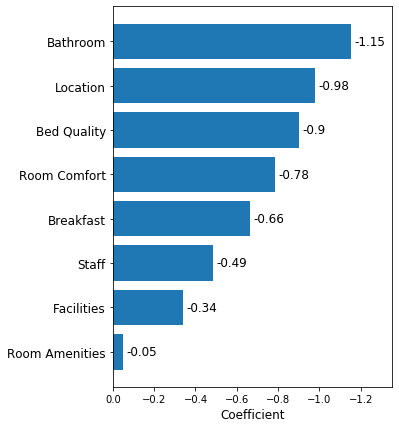

In [1595]:
fig,ax = plt.subplots(figsize=(5,7))
ax.barh(reg_topic_summary.index, reg_topic_summary['Weights'])
ax.set_yticks(reg_topic_summary.index)
ax.set_yticklabels(reg_topic_summary['Features'],fontdict={'fontsize':12})
ax.invert_yaxis()
ax.set_xlim(-1.35,0)
ax.invert_xaxis()
ax.set_xlabel('Coefficient',fontdict={'fontsize':12})

for i,v in enumerate(reg_topic_summary['Weights']):
    plt.text(v-0.015, i, str(round(v, 2)), color='black', va="center", fontsize=12)
    
plt.show()

### Feature importance countplot

In [1596]:
reg_hotel_feats_summary = reg_summary.loc[0:8].copy()
reg_hotel_feats_summary.sort_values(by=['Weights'],ascending=False,inplace=True)
reg_hotel_feats_summary.reset_index(drop=True,inplace=True)

reg_hotel_feats_summary.replace('hotel_stars','Stars',inplace=True)
reg_hotel_feats_summary.replace('hotel_comfort_rating','Comfort Rating',inplace=True)
reg_hotel_feats_summary.replace('hotel_facilities_rating','Facilities Rating',inplace=True)
reg_hotel_feats_summary.replace('hotel_staff_rating','Staff Rating',inplace=True)
reg_hotel_feats_summary.replace('hotel_wifi_rating','WiFi Rating',inplace=True)
reg_hotel_feats_summary.replace('hotel_location_rating','Location Rating',inplace=True)
reg_hotel_feats_summary.replace('hotel_cleanliness_rating','Cleanliness Rating',inplace=True)
reg_hotel_feats_summary.replace('hotel_value_rating','Value Rating',inplace=True)
reg_hotel_feats_summary.replace('hotel_overall_rating','Overall Rating',inplace=True)

In [1597]:
reg_hotel_feats_summary

,Features,Weights
0,Stars,26.822914
1,Comfort Rating,23.992888
2,Facilities Rating,18.750589
3,Staff Rating,9.586720
4,Location Rating,1.266847
5,WiFi Rating,1.115646
6,Overall Rating,-10.779470
7,Cleanliness Rating,-14.752988
8,Value Rating,-27.427301


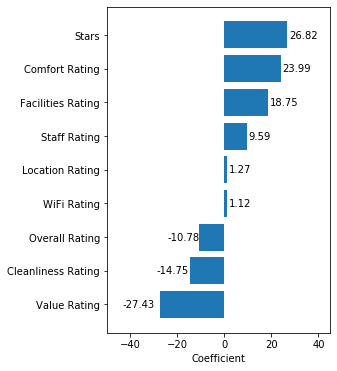

In [1598]:
fig,ax = plt.subplots(figsize=(4,6))
ax.barh(reg_hotel_feats_summary.index, reg_hotel_feats_summary['Weights'])
ax.set_yticks(reg_hotel_feats_summary.index)
ax.set_yticklabels(reg_hotel_feats_summary['Features'])
ax.invert_yaxis()
ax.set_xlim(-50,45)
ax.set_xlabel('Coefficient')

for i,v in enumerate(reg_hotel_feats_summary['Weights']):
    if v>0:
        plt.text(v+0.75, i, str(round(v, 2)), color='black', va="center", fontsize=10)
    else:
        plt.text(1.15*v-12, i, str(round(v, 2)), color='black', va="center", fontsize=10)        
    
plt.show()

### Location importance countplot

In [1599]:
reg_location_summary = reg_summary.loc[17:186].copy()
reg_location_summary.sort_values(by=['Weights'],ascending=False,inplace=True)
reg_location_summary.reset_index(drop=True,inplace=True)
reg_top_location_summary = reg_location_summary.loc[0:4].copy()
reg_bottom_location_summary = reg_location_summary.loc[165:].copy()

reg_top_location_summary.replace('hotel_address_zip_code_5dig_10065','10065',inplace=True)
reg_top_location_summary.replace('hotel_address_zip_code_5dig_10012','10012',inplace=True)
reg_top_location_summary.replace('hotel_address_zip_code_5dig_10023','10023',inplace=True)
reg_top_location_summary.replace('hotel_address_zip_code_5dig_10004','10004',inplace=True)
reg_top_location_summary.replace('hotel_address_zip_code_5dig_11944','11944',inplace=True)

reg_bottom_location_summary.reset_index(drop=True,inplace=True)
reg_bottom_location_summary.replace('hotel_address_zip_code_5dig_13209','13209',inplace=True)
reg_bottom_location_summary.replace('hotel_address_zip_code_5dig_13820','13820',inplace=True)
reg_bottom_location_summary.replace('hotel_address_zip_code_5dig_14625','14625',inplace=True)
reg_bottom_location_summary.replace('hotel_address_zip_code_5dig_11788','11788',inplace=True)
reg_bottom_location_summary.replace('hotel_address_zip_code_5dig_13090','13090',inplace=True)

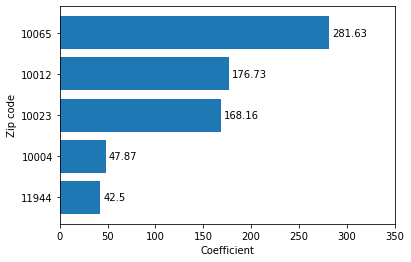

In [1600]:
fig,ax = plt.subplots(figsize=(6,4))
ax.barh(reg_top_location_summary.index, reg_top_location_summary['Weights'])
ax.set_yticks(reg_top_location_summary.index)
ax.set_yticklabels(reg_top_location_summary['Features'])
ax.invert_yaxis()
ax.set_xlim(0,350)
ax.set_xlabel('Coefficient')
ax.set_ylabel('Zip code')

for i,v in enumerate(reg_top_location_summary['Weights']):
    plt.text(v+3, i, str(round(v, 2)), color='black', va="center")
    
plt.show()

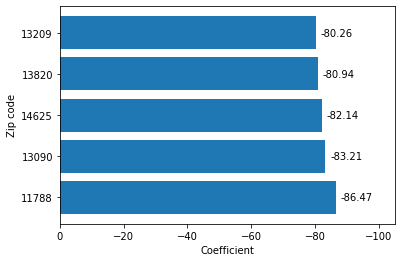

In [1601]:
fig,ax = plt.subplots(figsize=(6,4))
ax.barh(reg_bottom_location_summary.index, reg_bottom_location_summary['Weights'])
ax.set_yticks(reg_bottom_location_summary.index)
ax.set_yticklabels(reg_bottom_location_summary['Features'])
ax.invert_yaxis()
ax.set_xlim(-105,0)
ax.invert_xaxis()
ax.set_xlabel('Coefficient')
ax.set_ylabel('Zip code')

for i,v in enumerate(reg_bottom_location_summary['Weights']):
    plt.text(v-1.5, i, str(round(v, 2)), color='black', va="center")
    
plt.show()

### Pickle model

In [1524]:
regression_model_filename = './input_app/price_regression_model.sav'
pickle.dump(reg, open(regression_model_filename, 'wb'))

### Pickle additional parameters

In [1525]:
aux_info_1_filename = './input_app/categorical_features.sav'
pickle.dump(categorical_features, open(aux_info_1_filename, 'wb'))

aux_info_2_filename = './input_app/features_complete_list.sav'
pickle.dump(features_complete_list, open(aux_info_2_filename, 'wb'))

aux_info_3_filename = './input_app/features_complete_list_dummies.sav'
pickle.dump(train_test_scaled_inputs.columns.values, open(aux_info_3_filename, 'wb'))

## Predictions by varing parameters
(testing the web app output)

### Import pickled files

In [1526]:
reg_model = pickle.load(open('./input_app/price_regression_model.sav','rb'))
cat_feats = pickle.load(open('./input_app/categorical_features.sav','rb'))
feats_compl_list = pickle.load(open('./input_app/features_complete_list.sav','rb'))
feats_compl_list_dummies = pickle.load(open('./input_app/features_complete_list_dummies.sav','rb'))

### Input and test

In [1527]:
input_hotel = df_hotels_unique_names[df_hotels_unique_names['hotel_unique_name']=='Ace Hotel New York (10001)']

In [1528]:
display_info_hotel(input_hotel)

Hotel name:  Ace Hotel New York
---------------------
Negative mentions per topic: 
(0) Room Comfort:  36
(1) Staff:  17
(2) Breakfast:  15
(3) Facilities:  12
(4) Location:  15
(5) Bathroom:  34
(6) Room Amenities:  109
(7) Bed Quality:  26


In [1529]:
counts_delta_vec = [0,0,0,0,0,-34,0,0]
test_output = update_price(reg_model,cat_feats,feats_compl_list,feats_compl_list_dummies,input_hotel,counts_delta_vec)

In [1530]:
# original price, new price, % change
test_output

[167.84656136694883, 179.31737209652778, 6.834105290069823]